In this notebook the reference model for topological superconductivity in one dimension (1D) is introduced, the [Kitaev](https://iopscience.iop.org/article/10.1070/1063-7869/44/10S/S29) model (chain). We study this model because in one of its phases Majorana zero modes are supported. The interest in Majorana zero modes stems from the non-Abelian braiding statistics that could enable the realization of a topological quantum computer [DasSarma](https://www.nature.com/articles/npjqi20151). To simulate the Kitaev model the python package [kwant](https://kwant-project.org/) will be imported. Kwant is a versatile and powerful tool to build tight binding hamiltonians and solve transport-related problems.  

More information and details about Majorana zero modes can be found in these reviews: [Alicea](https://iopscience.iop.org/article/10.1088/0034-4885/75/7/076501) and [Aguado](https://www.sif.it/riviste/sif/ncr/econtents/2017/040/11/article/0). I also recommend to follow the online course [Topology in condensed matter](https://topocondmat.org) of Akhmerov et al.  

# Outline
- [1 - Kitaev model in real space](#1)
- [2 - Building the model with kwant](#2)
  - [2.1 Method 1](#2.1)
    -  [ Eigenenergies and eigenstates](#2.1.1)
  - [2.2 - Method 2](#2.2)
    -  [ Phases of the Kitaev model](#2.2.1)
- [3 - Kitaev model in k space](#3)
  - [3.1 Method 3](#3.1)


<a name="1"></a>
# Kitaev model in real space

The Kitaev model describes electrons in a chain with hopping energy $t$, chemical potential $\mu$, and superconducting gap $\Delta$,

\begin{equation}
H = \sum_{j=1}^N \bigl[ -t\bigl(c_j^{\dagger}c_{j+1} + c_{j+1}^{\dagger}c_j\bigr) 
-\mu c_j^{\dagger}c_j + \Delta c_j c_{j+1} + \Delta^*c_{j+1}^{\dagger}c_j^{\dagger}\bigr],
\label{Kitaham}\tag{1}
\end{equation}

where $c_j^{\dagger}$ ($c_j$) creates (annihilates) electrons at site $j$. Notice that hamiltonian (\ref{Kitaham}) describes spinless particles (neither spin indexes nor spin operators appear in this expression). In a following notebook a model supporting Majoranas and including spin will be presented. The creation and annihilation operators satisfy some relations, given the fermionic nature of electrons, 

\begin{eqnarray}
c_i c_j^{\dagger} + c_j^{\dagger}c_i &=& \delta_{i,j\,}, \label{fermalgebra}\tag{2} \\ 
c_i c_j + c_j c_i &=& 0\,. 
\end{eqnarray}

For simplicity we consider a homogeneous superconducting gap, i.e. $\Delta = |\Delta|e^{i\phi}$. In this case we use the transformations $c_j\rightarrow e^{-i\phi/2}c_j$ and  $c_j^{\dagger}\rightarrow e^{i\phi/2}c_j^{\dagger}$ to have a purely real superconducting gap. Let's use Eq. (\ref{fermalgebra}) to obtain a kind of "assymetric'' expression for the hamiltonian,

\begin{eqnarray}
&H = \frac{1}{2}\sum_{j=1}^N \bigl[ 
-t\bigl(c_j^{\dagger}c_{j+1} -c_{j+1}c_j^{\dagger} +c_{j+1}^{\dagger}c_j -c_jc_{j+1}^{\dagger} \bigr) 
-\mu\bigl( c_j^{\dagger}c_j - c_jc_j^{\dagger} +1\bigr) \\
&+|\Delta| \bigl(c_j c_{j+1} - c_{j+1}c_j  
+c_{j+1}^{\dagger}c_j^{\dagger} - c_j^{\dagger}c_{j+1}^{\dagger} \bigr)\bigr].
\end{eqnarray}

Let's arrange all the creation and annihilation operators as row and column vectors, $C^{\dagger}=(c^{\dagger}_1,\cdots,c_N^{\dagger},c_1,\cdots,c_N)$ and $C=(c_1,\cdots,c_N,c^{\dagger}_1,\cdots,c_N^{\dagger})^T$. The hamiltonian is now in what is called the  Bogoliubov-de Gennes formalism, 

\begin{eqnarray}
H = \frac{1}{2} C^{\dagger}\left(
\begin{array}{cc}
\hat{T} & \hat{\Delta} \\
-\hat{\Delta} & -\hat{T} \\
\end{array}
\right)C -\frac{\mu N}{2},
\label{Kita_BdG}\tag{3}
\end{eqnarray}

where $\hat{T}$ and $\hat{\Delta}$ are $N\times N$ matrices, 
\begin{eqnarray}
\begin{array}{cc}
\hat{T} = \left(
\begin{array}{ccccc}
-\mu & -t & & & \\
-t & -\mu & -t & & \\
& -t & -\mu & -t & \\
& & \ddots & \ddots & \ddots
\end{array}
\right),
&\!\mathrm{and}\,\,
\hat{\Delta} = \left(
\begin{array}{ccccc}
 & -|\Delta| & & & \\
|\Delta| & & -|\Delta| & & \\
& |\Delta| & & -|\Delta| & \\
& & \ddots & & \ddots
\end{array}
\right).
\end{array}
\end{eqnarray}

The last term in Eq. (\ref{Kita_BdG}) is just an energy shift and one can include it in a new definition of the hamiltonian. In a fully matricial form the hamiltonian reads,
$$H = \frac{1}{2}C^{\dagger}\bigl(\hat{T}\tau_z + i\hat{\Delta}\tau_y\bigr)C,$$

where $\boldsymbol{\tau}=(\tau_x,\tau_y,\tau_z)$ are pauli matrices acting in what is called the Nambu space (electron and hole space). $\mathscr{H}=\hat{T}\tau_z + i\hat{\Delta}\tau_y$ is a sparse matrix with dimension $2N\times 2N$ and 7 non-zero diagonals. The eigenvalues and eigenvectors of this matrix can be computed with any linear solver algorithm, I'll use the python package [kwant](https://kwant-project.org/) to build this hamiltonian matrix.

In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh

C:\Users\victo\anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


<a name="2"></a>
# Building the system with kwant

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\bra}[1]{\langle #1|}$
Another form to write the Kitaev hamiltonian, and which appears convenient for kwant, consists in using the ket $(\ket{})$ and bra $(\bra{})$ notation. For example, in this notation $\hat{T}=\sum_j \bigl(-\mu\ket{j}\bra{j}-t\ket{j}\bra{j+1} - t\ket{j+1}\bra{j}\bigr)$.    

\begin{equation}
\mathscr{H} = -\sum_j \bigl[ \mu\tau_z\ket{j}\bra{j} +\bigl(t\tau_z+i|\Delta|\tau_y\bigr)\ket{j}\bra{j+1} 
+\bigl(t\tau_z-i|\Delta|\tau_y\bigr)\ket{j+1}\bra{j}\bigr]
\end{equation}

<a name="2.1"></a>
## Method 1
The lines of code below implement the hamiltonian above.

In [2]:
# Defining lattice parameters and energy values 
alat = 0.25;   Nlat = 80
t = 1.0;  mu = -0.2; Delta = 0.1

# Defining the Pauli matrices acting in the Nambu space
taux = np.array([[0,1],[1,0]])
tauy = np.array([[0,-1j],[1j,0]])
tauz = np.array([[1,0],[0,-1]])

In [3]:
# From the kwant module `lattice' a 1-dimensional lattice is set
# with lattice constant `alat' and number of orbitals = 2
lat = kwant.lattice.chain(alat, norbs=2)

# The kwant module `builder' defines a tight binding system from a graph
# where the nodes and vertices correspond to onsite and hopping energies, respectively
syst = kwant.Builder()
syst[(lat(x) for x in range(Nlat))] = -mu*tauz
syst[lat.neighbors()] = -t*tauz -1j*Delta*tauy

# The last step in the construction of the tight binding system is its finalization
syst=syst.finalized()

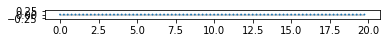

Plotting the nodes and vertices of the lattice


In [4]:
kwant.plot(syst)
print('Plotting the nodes and vertices of the lattice')

<a name="2.1.1"></a>
### Eigenenergies and Eigenstates
Let's now calculate some eigenvalues and eigenstates around the superconducting gap. Kwant provides a method to obtain the hamiltonian either as a sparse or dense matrix `hamiltonian_submatrix()`.   

In [5]:
ham = syst.hamiltonian_submatrix(sparse=True)
nrts = 10
Evals, Evecs = eigsh(ham, k=nrts, which='SM')

In [6]:
indlist = np.argsort(Evals)
Evals = Evals[indlist]
Evecs = Evecs[::,indlist]
rho = kwant.operator.Density(syst, np.eye(2))

The cell below plots the energies and the first three states with $E_n>0$. We see that while the state with n=5 is localized at the edges (Majorana state), the other two are extended all over the lattice (bulk states). 

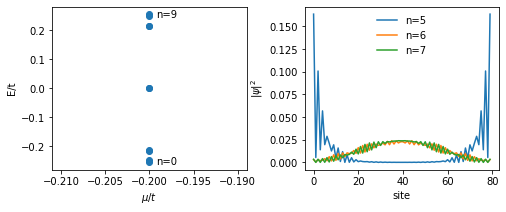

In [7]:
fig, sub = plt.subplots(1,2, figsize=(8,3))
sub[0].plot(mu*np.ones(len(Evals)),Evals,'o')
sub[0].text(0.996*mu,1.03*Evals[0],'n=0')
sub[0].text(0.996*mu,0.95*Evals[-1],'n='+str(nrts-1))

for ii in range(5,8):
    sub[1].plot(rho(Evecs[::,ii]), label='n='+str(ii))
    
sub[0].set_ylabel('E/t')
sub[0].set_xlabel(r'$\mu/t$')
sub[1].set_ylabel(r'$|\psi|^2$')
sub[1].set_xlabel('site')
sub[1].legend(frameon=False)
plt.subplots_adjust(wspace=0.3)

<a name="2.2"></a>
## Method 2
In the next lines of code we are going to set exactly the same system as before but using a slightly different method. The goal with this method is to be able to manipulate the parameters of the system, for example to visualize its phases. The key ingredients are the functions `onsite()` and `hop()` which depend on lattice cordinates and some other parameters.  

In [8]:
def Ksystem(aa, L):
    
    def interval_shape(pos):
        x, = pos
        return  0 <= x < L 
    
    def onsite(site, mu):
        return  -mu*tauz
    
    def hop(site1, site2, t, Delta):
        return -t*tauz  - 1j*Delta*tauy
    
    lat = kwant.lattice.chain(aa,norbs=2)
    syst = kwant.Builder()
    syst[lat.shape(interval_shape, (0, ))] = onsite
    syst[lat.neighbors()] = hop
    syst = syst.finalized()
    
    return syst

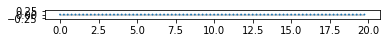

Plotting the nodes and vertices of the lattice


In [9]:
Ll = 20
syst = Ksystem(alat,Ll)
kwant.plot(syst)
print('Plotting the nodes and vertices of the lattice')

<a name="2.2.1"></a>
### Phases of the Kitaev model 

Kwant reads the input parameters of the `onsite()` and `hop()` functions from a python dictionary. The values can be updated at any time, for example to generate a dependence of the energy on the updated value. The function `E_wvf()` calculates the energy and some eigenstates as a function of the chemical potential $\mu$. The update of the chemical potential is executed by the instruction `params['mu'] = mu` in the for loop below. 

In [10]:
params = dict(t=1,mu=-0.2,Delta=0.1)

In [11]:
def E_wvf(muarr,mua,mub,nrts):
  
    if mua < muarr[0] or mua > muarr[-1]:
        ia = 0
    else:
        ia = (mua - muarr[0])/(muarr[1]-muarr[0])
        ia = int(round(ia))
    if mub > muarr[-1] or mub < muarr[0]:
        ib = len(muarr)
    else:
        ib = (mub - muarr[0])/(muarr[1]-muarr[0])
        ib = int(round(ib))
    Elist = []
    indlist = [ia,ib]
    ttlist = ['(a)','(b)','(c)']
    vlist = []
    
    for ii, mu in enumerate(muarr):
        params['mu'] = mu
        ham = syst.hamiltonian_submatrix(params=params,sparse=True)
        if ii == ia or ii == ib:
            Evals, Evecs = eigsh(ham, k=nrts, which='SM')
            indarr = np.argsort(Evals)
            Evals = Evals[indarr]
            vlist.append(Evecs[::,indarr])
        else: 
            Evals = eigsh(ham, k=nrts, which='SM', return_eigenvectors=False)
            Evals = np.sort(Evals)
            
        Elist.append(Evals)
    
    Emtx = np.array(Elist)
    rho = kwant.operator.Density(syst, np.eye(2))
    
    nsites = Ll/alat;  nsites = int(round(nsites))

    fig, sub = plt.subplots(1,3, figsize=(10,3))
    
    Eup = 2.0*Emtx[0,0]; Edw = 2.0*Emtx[0,-1] 
    sub[0].plot(muarr, Emtx)
    sub[0].set_ylim(Edw,Eup)
    sub[0].set_xlabel(r'$\mu/t$')
    sub[0].set_ylabel(r'$E/t$', rotation='horizontal')
    sub[0].set_title(ttlist[0])
    for jj in range(2):
        sub[0].plot(muarr[indlist[jj]]*np.ones(7),np.linspace(Edw,Eup,7), '--k', alpha=0.5)
        sub[1+jj].set_xticks(np.linspace(0,nsites,5))
        sub[1+jj].set_xticklabels(np.linspace(0,Ll,5))
        sub[1+jj].set_xlabel('x')
        sub[1+jj].set_ylabel(r'$|\psi\,|^2$', rotation='horizontal', labelpad=8, y=0.48)
        sub[1+jj].set_title(ttlist[1+jj]+r'$\;\;\mu/t=$'+str.format('{:.2f}',muarr[indlist[jj]]))
        
    for ii in range(3):
        nhlf = int(0.5*nrts)
        En = Emtx[ia,nhlf+ii]
        sub[1].plot(rho(vlist[0][::,nhlf+ii]), label='E='+str.format('{:.3f}',En))
        sub[2].plot(rho(vlist[1][::,nhlf+ii]))
            
    sub[1].legend(frameon=False)
    fig.subplots_adjust(wspace=0.36)
        

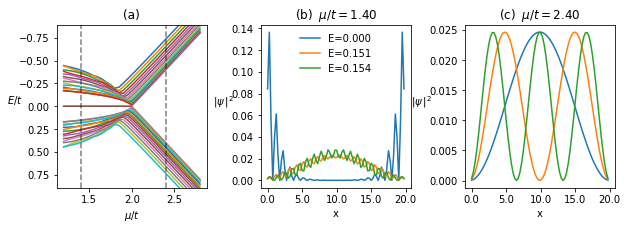

In [12]:
muarr = np.linspace(1.2,2.8,33)
E_wvf(muarr,1.4,2.4,30)

Figure (a) shows the energy spectrum of the Kitaev chain as a function of the chemical potential $\mu$. Notice that zero energy states emerge for $\mu/t < 2$ (the topologically nontrivial phase). Fig. (b) shows that while zero energy states are located at the edges, non-zero energy states are extended all over the sample. Fig. (c) plots three states when $\mu/t > 2$ (the topologically trivial phase).   

<a name="3"></a>
# Kitaev model in $k$ space
In this section we deal with the Kitaev model in the reciprocal or $k$ space. Let's consider the 1D lattice is  periodic so one can define creation and annihilation operators in the $k$ space using the fourier transform,

\begin{equation}
\begin{array}{cc}
c_k = \frac{1}{\sqrt{N}}\sum_{j=1}^N e^{-ikja}c_j, &
c_k^{\dagger} = \frac{1}{\sqrt{N}}\sum_{j=1}^N e^{ikja}c_j^{\dagger}, &
\end{array}
\end{equation}

where $N$ is the number of sites and $a$ is the lattice constant. Inverse operators can similarly be defined,

\begin{equation}
\begin{array}{cc}
c_j = \frac{1}{\sqrt{N}}\sum_{k} e^{ikja}c_k, &
c_j^{\dagger} = \frac{1}{\sqrt{N}}\sum_{k} e^{-ikja}c_k^{\dagger}. &
\label{opsktrans}\tag{4}
\end{array}
\end{equation}

From the periodicity of the system, i.e. $c_{j+N} = c_j$, one obtains that $ka=\frac{2\pi}{N}n$, where $n$ takes integer values (positive and negative ones). Let's apply the transformations of Eq. (\ref{opsktrans}) to the kinetic term of the Kitaev model in real space,

\begin{eqnarray}
& -t\sum_{j=1}^N\bigl(c_j^{\dagger}c_{j+1} + c_{j+1}^{\dagger}c_j\bigr) =
\frac{-t}{N}\sum_k\sum_{k'} \sum_{j=1}^N e^{i(k'-k)ja}\bigl(
c_k^{\dagger}c_{k'}e^{ika} + c_{k}^{\dagger}c_{k'}e^{-ik'a}\bigr) = \\
&-t\sum_{k,k'}\delta_{k',k}\bigl( e^{ika} + e^{-ik'a}\bigr) c_k^{\dagger}c_{k'} =
-2t \sum_k \cos{ka}\,  c_k^{\dagger}c_k\,.
\end{eqnarray}

In a middle step, the formula $\frac{1}{N}\sum_j e^{i(k'-k)ja}=\delta_{k',\,k}$ was employed. Following identical steps with the other terms in the Kitaev hamiltonian we obtain,

\begin{equation}
H = \sum_k \bigl(-2t\cos{ka}-\mu\bigr)  c_k^{\dagger}c_k 
+|\Delta|\sum_k e^{-ika}\bigl(c_kc_{-k} + c_k^{\dagger}c_{-k}^{\dagger}\bigr).
\end{equation}

By noticing that: 1) functions $f(k)=c_kc_{-k}$, and $g(k)=c_k^{\dagger}c_{-k}^{\dagger}$ are odd under $k$ and 2) the sum over $k$ is between $-N/2$ and $N/2,$ the kitaev hamiltonian in the reciprocal space simplifies to  

\begin{eqnarray}
&H = \sum_{k} \bigl(-2t\cos{ka}-\mu\bigr) c_k^{\dagger}c_k  
-2i|\Delta|\sum_{k>0} \sin{ka} \bigl(c_kc_{-k} + c_k^{\dagger}c_{-k}^{\dagger}\bigr)=\\
&\sum_{k>0} \bigl(-2t\cos{ka}-\mu\bigr)\bigl( c_k^{\dagger}c_k - c_{-k}c_{-k}^{\dagger}\bigr)
-2i|\Delta|\sin{ka} \bigl(-c_{-k}c_k + c_k^{\dagger}c_{-k}^{\dagger}\bigr).
\end{eqnarray}

In a middle step, the term $\sum_{k>0} \bigl(-2t\cos{ka}-\mu\bigr)$ was discarded since it's only an energy shift. The resulting expression above, arranged in a Bogoliubov-de Gennes notation, yields 

\begin{equation}
H = \sum_{k>0} \left(c_k^{\dagger},c_{-k}\right)\left(
\begin{array}{cc}
-2t\cos{ka} -\mu & -2i|\Delta| \sin{ka}\\
2i|\Delta|\sin{ka} & 2t\cos{ka} +\mu
\end{array}
\right)\left(
\begin{array}{c}
c_k \\
c_{-k}^{\dagger}
\end{array}
\right).
\label{kitaink}\tag{5}
\end{equation}

The energies are straightforwardly calculated,

\begin{equation}
E = \sqrt{\bigl(2t\cos{ka} +\mu\bigr)^2 + 4 |\Delta|^2\sin^2\!{ka}}\,.
\label{Ebands}\tag{6}
\end{equation}

Let's now consider that $ka$ is a small number and expand the trigonometric functions in Eq. (\ref{kitaink}). In first order we obtain,

$$H(k)\approx\left(
\begin{array}{cc}
-2t -\mu & -2i|\Delta| ka \\
2i|\Delta| ka & 2t + \mu
\end{array}
\right)= \tilde{\Delta}\sigma_y k + \tilde{m}\sigma_z,$$

where $\tilde{m}=-(2t+\mu)$ and $\tilde{\Delta}= 2a|\Delta|$. This is a 1D Dirac hamiltonian with the 'mass' term given by $- (2t+\mu)$. Notice that the mass changes sign at $\mu/t=-2$, the interface between the two distinct topological phases. 

In second order we obtain,

\begin{equation}H(k)\approx\left(
\begin{array}{cc}
-2t -\mu + ta^2k^2& -2i|\Delta| ka \\
2i|\Delta| ka & 2t + \mu - ta^2k^2
\end{array}
\right)= \bigl(\tilde{a}k^2 -\tilde{u}\bigr)\sigma_z + \tilde{\Delta}\sigma_y k,
\label{K_conti2}\tag{7}
\end{equation}

where $\tilde{a} = ta^2$ and $\tilde{u}=2t + \mu$. Let's implement Eqs.(\ref{kitaink}) and (\ref{K_conti2}) in the following lines. One of the features of kwant is that it internally calculates the hamiltonian in $k$ space from the equivalent one in real space. To do that kwant needs: 1) a translational symmetry and 2) a transformation where translational symmetries are replaced by linear momenta. In the function `K_period_sys()` these two requirements are implemented in the lines of code:  `kwant.Builder(kwant.TranslationalSymmetry([]))` and ` kwant.wraparound.wraparound()`, respectively.

In [13]:
def K_period_sys(aa):
        
    def onsite(site, mu):
        return  -mu*tauz
    
    def hop(site1, site2, t, Delta):
        return -t*tauz  - 1j*Delta*tauy
    
    lat = kwant.lattice.chain(aa,norbs=2)
    build = kwant.Builder(kwant.TranslationalSymmetry([aa]))
    build[lat(0)] = onsite
    build[lat.neighbors()] = hop
    infisyst = kwant.wraparound.wraparound(build).finalized()
    
    return infisyst

In [14]:
from ipywidgets import interactive

The function below, `spectrum()`, calculates the energy of the periodic system defined by the function above, `K_period_sys()`. Notice the line of code `params['k_x'] = kx` adds linear momentum values to the dictionary that kwant reads to implement the system.

In [15]:
def spectrum(chem,supgap):
    
    Elist = []
    params['mu'] = chem
    params['Delta'] = supgap 
    tval = params.get('t')
    
    period_syst = K_period_sys(alat)
    
    karr = np.linspace(0,np.pi,39)
    for kx in karr:
        params['k_x'] = kx
        ham = period_syst.hamiltonian_submatrix(params=params, sparse=False)
        Evals = eigh(ham, eigvals_only=True)
        Elist.append(Evals)

        Emtx = np.array(Elist)
    
    Eanalarr = np.sqrt((2*tval*np.cos(karr)+chem)**2+ 4*supgap**2*np.sin(karr)**2)
    
    fig, sub = plt.subplots(1, figsize=(5,4))

    for ii in range(1,-3,-2):
        sub.plot(ii*karr,Emtx[::,0], '-m')
        for jj in range(1,-3,-2):
            sub.plot(jj*karr[::4],ii*Eanalarr[::4], 'oc' )
        sub.plot(ii*karr,Emtx[::,1], '-m')
    
    sub.set_title(r'$\mu/t=$'+str(chem)+r'$,\,\Delta/t=$'+str(supgap))
    sub.set_xlabel(r'$ka$', fontsize=13)    
    sub.set_ylabel(r'$E$', fontsize=13)
    sub.legend(['kwant','analytics'],frameon=False)

In [16]:
w = interactive(spectrum, chem=(-2.5,2.5), supgap=(0.0,0.8))
display(w)

interactive(children=(FloatSlider(value=0.0, description='chem', max=2.5, min=-2.5), FloatSlider(value=0.4, de…

The figure above shows the energy spectrum of the Kitaev model in $k$ space. The energy is $2\pi$ periodic, as expected, and the comparison between the analytic expression (6) and the calculation with kwant agrees well. Users can slide the buttons `chem` and `supgap` to manipulate the energy spectrum. Try finding the values of $\mu$ where the gap closes. 

<a name="3.1"></a>
## Method 3

Let's now describe another method to define a system in kwant. This functionality is very convenient if one has the hamiltonian in a continuous notation, i.e. given in terms of the continuous operators $\mathbf{p}$ ($\mathbf{k}$) and $\mathbf{r}$. We will use this method to implement the hamiltonian of Eq. (7). In the cell below we start by declaring the hamiltonian as a string compatible with the [continuum](https://kwant-project.org/doc/1/reference/kwant.continuum) module of kwant and  the python package [sympy](https://www.sympy.org). Then, the function `kwant.continuum.discretize()` translates the features of the continuum model into features of the tight binding model, e.g. how the momentum operator translates to hoppings. In a subsequent step the module `kwant.Builder()` is used as in previous methods, and finally the empty tight binding model is filled with the hoppings and onsite functions that were translated from the string hamiltonian, `syst_infin.fill()`. This method works for both hamiltonians in real and $k$ space. In this particular case we are using it to calculate the energy spectrum of the Kitaev model in $k$ space.    

In [17]:
ham_cont = """
    (a*k_x**2  - mu) * sigma_z
    + Delta * k_x *sigma_y
"""

hamiltonian = kwant.continuum.sympify(ham_cont)
hamiltonian

C:\Users\victo\anaconda3\lib\site-packages\ipykernel_launcher.py:6: KwantDeprecationWarning: Accessing kwant.continuum without an explicit import is deprecated. Instead, explicitly 'import kwant.continuum'.
  


Matrix([
[a*k_x**2 - mu,     -I*Delta*k_x],
[  I*Delta*k_x, -(a*k_x**2 - mu)]])

In [18]:
def Q_period_sys():
    
    def interval_shape(nsites):
        def shape(site):
            return 0 <= site.pos[0] < alat*nsites
        return shape

    template = kwant.continuum.discretize(
        ham_cont, 'x', grid=alat)
    syst_infin = kwant.Builder(kwant.TranslationalSymmetry([alat]))

    syst_infin.fill(template, interval_shape, (0,))
    infin_syst = kwant.wraparound.wraparound(syst_infin).finalized()
    
    return infin_syst

Reminder: The dictionary of parameters has been updated as the calculations leading to Eq. (7) indicated, $\tilde{\Delta}= 2a|\Delta|$, $\tilde{a} = ta^2$ and $\tilde{u}=2t + \mu$. 

In [19]:
def spectr_compar(chem,supgap):
    
    Elist = []
    params['mu'] = chem
    params['Delta'] = supgap 
    tval = params.get('t')
    
    period_syst = Q_period_sys()
    massinv = t*alat**2; mutilde = 2*t + params.get('mu'); Deltatilde = 2*alat*params.get('Delta')
    newparams = dict(a=massinv,mu=mutilde,Delta=Deltatilde)
    
    karr = np.linspace(0,np.pi,39)
    for kx in karr:
        newparams['k_x'] = kx
        ham = period_syst.hamiltonian_submatrix(params=newparams, sparse=False)
        Evals = eigh(ham, eigvals_only=True)
        Elist.append(Evals)

        Emtx = np.array(Elist)
    
    Eanalarr = np.sqrt((2*tval*np.cos(karr)+chem)**2+ 4*supgap**2*np.sin(karr)**2)
    
    fig, sub = plt.subplots(1, figsize=(5,4))

    for ii in range(1,-3,-2):
        sub.plot(ii*karr,Emtx[::,0], '-m')
        for jj in range(1,-3,-2):
            sub.plot(jj*karr[::4],ii*Eanalarr[::4], 'oc' )
        sub.plot(ii*karr,Emtx[::,1], '-m')
            
    sub.set_title(r'$\mu/t=$'+str(chem)+r'$,\,\Delta/t=$'+str(supgap))
    sub.set_xlabel(r'$ka$', fontsize=13)    
    sub.set_ylabel(r'$E$', fontsize=13)
    sub.legend(['kwant (continuous)','analytics'],frameon=False)

In [20]:
w = interactive(spectr_compar, chem=(-2.5,2.5), supgap=(0.0,0.8))
display(w)

interactive(children=(FloatSlider(value=0.0, description='chem', max=2.5, min=-2.5), FloatSlider(value=0.4, de…

In the figure above we check that methods 2 and 3 yield the same results for the energy spectrum of the kitaev hamiltonian in $k$ space.